In [1]:
import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import os

C:\Users\Justin\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\Justin\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Justin\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1

In [2]:
batch_size = 256
num_classes = 10
epochs = 100
data_augmentation = True
# num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

In [3]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [4]:
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [5]:
model = Sequential()
model.add(Conv2D(filters = 96, kernel_size = (11, 11), strides = (4, 4), padding = 'valid', input_shape = x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (3, 3), strides = (1, 1), padding = "same"))

model.add(Conv2D(filters = 256, kernel_size = (5, 5), strides = (1, 1), padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (3, 3), strides = (1, 1), padding = "same"))

model.add(Conv2D(filters = 384, kernel_size = (3, 3), strides = (1, 1), padding = 'same'))
model.add(Activation('relu'))
model.add(Conv2D(filters = 384, kernel_size = (3, 3), strides = (1, 1), padding = 'same'))
model.add(Activation('relu'))
model.add(Conv2D(filters = 256, kernel_size = (3, 3), strides = (1, 1), padding = 'same'))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size = (3, 3), strides = (1, 1), padding = "same"))
model.add(Flatten())
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 6, 6, 96)          34944     
_________________________________________________________________
activation (Activation)      (None, 6, 6, 96)          0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 96)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 256)         614656    
_________________________________________________________________
activation_1 (Activation)    (None, 6, 6, 256)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 256)         0         
_________________________________________________________________
conv

In [6]:
import tensorflow as tf
opt = tf.keras.optimizers.Adam(lr=0.0001, decay=1e-8)

In [7]:
# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [8]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [9]:
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    hist = model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=0)

Using real-time data augmentation.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
196/196 [==============================] - 29s 147ms/step - loss: 1.8086 - acc: 0.3220 - val_loss: 1.6315 - val_acc: 0.3964
Epoch 2/100
196/196 [==============================] - 27s 136ms/step - loss: 1.5309 - acc: 0.4372 - val_loss: 1.4992 - val_acc: 0.4547
Epoch 3/100
196/196 [==============================] - 28s 145ms/step - loss: 1.4178 - acc: 0.4862 - val_loss: 1.3284 - val_acc: 0.5177
Epoch 4/100
196/196 [==============================] - 28s 141ms/step - loss: 1.3180 - acc: 0.5250 - val_loss: 1.2382 - val_acc: 0.5555
Epoch 5/100
196/196 [==============================] - 27s 140ms/step - loss: 1.2581 - acc: 0.5454 - val_loss: 1.3093 - val_acc: 0.5377
Epoch 6/100
196/196 [==============================] - 27s 137ms/step - loss: 1.2229 - acc: 0.5625 - val_loss: 1.1795 - val_acc: 0.5775
Epoch 7/100
196/196 [==============================] - 27s 140ms/step - loss: 1.1667 - acc: 0.5847 - 

In [10]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at C:\Users\Justin\Desktop\Assignment1\saved_models\keras_cifar10_trained_model.h5 


In [11]:
# Score trained model.
train_scores = model.evaluate(x_train, y_train, verbose=1)
print('Test loss:', train_scores[0])
print('Test accuracy:', train_scores[1])

test_scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])

50000/50000 [==============================] - 7s 147us/sample - loss: 0.0707 - acc: 0.9761
Test loss: 0.07067751465693116
Test accuracy: 0.97606
10000/10000 [==============================] - 1s 145us/sample - loss: 1.2964 - acc: 0.7178
Test loss: 1.2963615785598754
Test accuracy: 0.7178


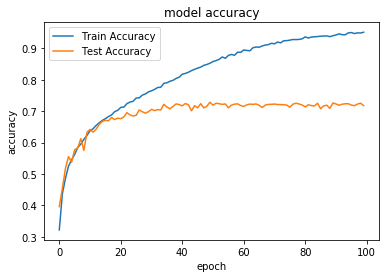

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train Accuracy', 'Test Accuracy'], loc='upper left')
plt.show()


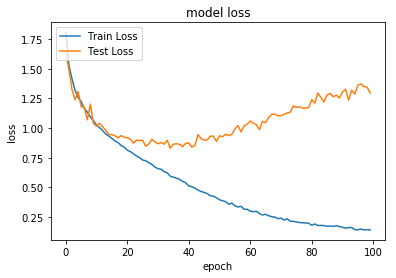

In [14]:
## summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train Loss', 'Test Loss'], loc='upper left')
plt.show()

In [15]:
model2 = Sequential()
model2.add(Conv2D(filters = 32, kernel_size = (5, 5), strides = (1, 1), padding = 'same', input_shape = x_train.shape[1:]))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size = (2, 2), strides = (1, 1), padding = "valid"))

model2.add(Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), padding = 'same'))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size = (2, 2), strides = (1, 1), padding = "valid"))

model2.add(Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), padding = 'same'))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size = (2, 2), strides = (1, 1), padding = "valid"))

model2.add(Flatten())
model2.add(Dense(500))
model2.add(Activation('relu'))
model2.add(Dense(num_classes))
model2.add(Activation('softmax'))

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        2432      
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 31, 31, 64)        18496     
_________________________________________________________________
activation_8 (Activation)    (None, 31, 31, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 30, 30, 128)       73856     
__________

In [145]:
def softmax(a) :
    exp_a = np.exp(a)
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a    
    return y

In [164]:
# Generate soft targets
from tensorflow.keras.layers import Activation, Lambda, concatenate
from tensorflow.keras.models import Model
temperature = 1.0
student_model1 = model
soft_model = Model(inputs = student_model1.layers[0].input, outputs = student_model1.layers[-2].output)
logits = soft_model.predict(x_train)
logits_T = logits / temperature
y_train_soft = np.array([softmax(logit) for logit in logits_T])

In [175]:
from keras.losses import categorical_crossentropy
def knowledge_distillation_loss(hard_target, soft_target, y_pred, lambda_value):
    Loss_teacher = categorical_crossentropy(hard_target, y_pred)
    Loss_student = categorical_crossentropy(soft_target, y_pred)
    return lambda_value * Loss_teacher + (1-lambda_value) * Loss_student

In [176]:
model2 = Sequential()
model2.add(Conv2D(filters = 32, kernel_size = (5, 5), strides = (1, 1), padding = 'same', input_shape = x_train.shape[1:]))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size = (2, 2), strides = (1, 1), padding = "valid"))

model2.add(Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), padding = 'same'))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size = (2, 2), strides = (1, 1), padding = "valid"))

model2.add(Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), padding = 'same'))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size = (2, 2), strides = (1, 1), padding = "valid"))

model2.add(Flatten())
model2.add(Dense(500))
model2.add(Activation('relu'))
model2.add(Dense(num_classes))
model2.add(Activation('softmax'))

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 32, 32, 32)        2432      
_________________________________________________________________
activation_39 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 31, 31, 64)        18496     
_________________________________________________________________
activation_40 (Activation)   (None, 31, 31, 64)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 30, 30, 128)       73856     
__________

In [180]:
opt = tf.keras.optimizers.Adam(lr=0.0001, decay=1e-8)
model2.compile(loss=lambda y_ture, y_pred: knowledge_distillation_loss(y_train, y_train_soft, y_pred, lambda_value = 0.1),
              optimizer=opt,
              metrics=['accuracy'])

In [182]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

# Fit the model on the batches generated by datagen.flow().
hist2 = model2.fit_generator(datagen.flow(x_train, y_train,
                                          batch_size=batch_size),
                             epochs=5,
                             validation_data=(x_test, y_test),
                             workers=0)

Epoch 1/5


InvalidArgumentError: Incompatible shapes: [50000,10] vs. [256,10]
	 [[{{node loss_8/activation_43_loss/mul_1}}]]
	 [[{{node loss_8/mul}}]]

In [ ]:
model3 = Sequential()
model3.add(Conv2D(filters = 32, kernel_size = (5, 5), strides = (1, 1), padding = 'same', input_shape = x_train.shape[1:]))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size = (2, 2), strides = (1, 1), padding = "valid"))

model3.add(Conv2D(filters = 32, kernel_size = (1, 1), strides = (1, 1), padding = 'same'))
model3.add(Conv2D(filters = 32, kernel_size = (3, 3), strides = (1, 1), padding = 'same'))
model3.add(Conv2D(filters = 64, kernel_size = (1, 1), strides = (1, 1), padding = 'same'))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size = (2, 2), strides = (1, 1), padding = "valid"))

model3.add(Conv2D(filters = 64, kernel_size = (1, 1), strides = (1, 1), padding = 'same'))
model3.add(Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), padding = 'same'))
model3.add(Conv2D(filters = 128, kernel_size = (1, 1), strides = (1, 1), padding = 'same'))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size = (2, 2), strides = (1, 1), padding = "valid"))

model3.add(Flatten())
model3.add(Dense(500))
model3.add(Activation('relu'))
model3.add(Dense(num_classes))
model3.add(Activation('softmax'))

model3.summary()